In [1]:
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF

In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

def process_pcap(pcap_file, port=5000, window_size=100):
    if not os.path.isfile(pcap_file):
        raise FileNotFoundError(f"Pcap file '{pcap_file}' not found.")

    csv_file = os.path.splitext(os.path.basename(pcap_file))[0] + '_data.csv'

    tshark_command = [
        'tshark',
        '-r', pcap_file,
        '-Y', f'tcp.port == {port}',
        '-T', 'fields',
        '-e', 'frame.time_epoch',
        '-e', 'tcp.seq',
        '-e', 'tcp.len',
        '-e', 'tcp.analysis.retransmission',
        '-e', 'tcp.analysis.ack_rtt',
        '-E', 'header=y',
        '-E', 'separator=,',
        '-E', 'quote=d',
        '-E', 'occurrence=f'
    ]

    with open(csv_file, 'w') as f:
        subprocess.run(tshark_command, stdout=f, stderr=subprocess.PIPE)

    df = pd.read_csv(
        csv_file,
        names=['timestamp', 'seq', 'len', 'retransmission', 'ack_rtt'],
        header=0,
        dtype={
            'timestamp': float,
            'seq': int,
            'len': int,
            'retransmission': str,  
            'ack_rtt': float
        }
    )

    df.sort_values('timestamp', inplace=True)
    df.reset_index(drop=True, inplace=True)

    df['iat_sec'] = df['timestamp'].diff()
    df['iat_ms'] = df['iat_sec'] * 1000
    df['jitter_ms'] = df['iat_ms'].diff().abs()
    df['is_retransmission'] = df['retransmission'].notna()
    df['expected_seq'] = df['seq'].shift(1) + df['len'].shift(1)
    df['seq_gap'] = df['seq'] - df['expected_seq']
    df['packet_loss'] = df['seq_gap'] > 0
    df['rtt_ms'] = df['ack_rtt'] * 1000
    start_time = df['timestamp'].iloc[0] if len(df) > 0 else 0
    df['relative_time'] = df['timestamp'] - start_time
    df['packet_index'] = df.index + 1
    df['cumulative_loss'] = df['packet_loss'].cumsum()
    df['jitter_roll_ms'] = df['jitter_ms'].rolling(window=window_size, min_periods=1).mean()
    if df['rtt_ms'].notna().any():
        df['rtt_roll_ms'] = df['rtt_ms'].rolling(window=window_size, min_periods=1).mean()
    else:
        df['rtt_roll_ms'] = np.nan
    return df


In [3]:
pcaps = [
    './captures/competing/cubic_30_100.pcap',
    './captures/competing/reno_30_100.pcap',
    './captures/competing/l4s_30_100.pcap',
    './captures/competing/prague_30_100.pcap',
]
dfs = []
labels = []
for pcap_file in pcaps:
    df = process_pcap(pcap_file, port=5000, window_size=100)
    dfs.append(df)
    label_name = 'TCP ' +os.path.splitext(os.path.basename(pcap_file))[0].split('_')[0]
    labels.append(label_name)

In [10]:
def plot_jitter(dfs, labels):
    plt.figure(figsize=(12, 6))
    for df, label in zip(dfs, labels):
        if df['jitter_ms'].notna().any():
            plt.plot(df['relative_time'], df['jitter_ms'], linewidth=0.5, label=label)
    plt.xlabel('Time (s from start)')
    plt.ylabel('Jitter (ms)')
    plt.title('TCP Jitter Over Relative Time')
    plt.grid(True)
    # plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_rtt(dfs, labels):
    plt.figure(figsize=(12, 6))
    for df, label in zip(dfs, labels):
        if df['rtt_ms'].notna().any():
            plt.plot(df['relative_time'], df['rtt_ms'], linewidth=1, label=label)
    plt.xlabel('Time (s from start)')
    plt.ylabel('RTT (ms)')
    plt.title('RTT vs Relative Time')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    # plt.yscale('log')
    plt.show()

def plot_jitter_rolling(dfs, labels, window_size=100):

    plt.figure(figsize=(12, 6))
    for df, label in zip(dfs, labels):
        if df['jitter_ms'].notna().any():
            df_clean = df.dropna(subset=['relative_time', 'jitter_ms'])
            df_sorted = df_clean.sort_values('relative_time')
            df_sorted['jitter_roll_avg'] = df_sorted['jitter_ms'].rolling(window=window_size, min_periods=1).mean()
            plt.plot(df_sorted['relative_time'], df_sorted['jitter_roll_avg'], label=f'{label}',linestyle='-',marker='',linewidth=2)
    
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Jitter (ms)', fontsize=12)
    plt.title(f'Jitter vs Time', fontsize=14)
    plt.ylim([0, 20])
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig('jitter_30_100_competing.pdf')
    plt.show()

def plot_rtt_rolling(dfs, labels, window_size=100):
    plt.figure(figsize=(12, 6))
    for df, label in zip(dfs, labels):
        if df['rtt_roll_ms'].notna().any():
            df_clean = df.dropna(subset=['relative_time', 'rtt_roll_ms'])
            df_sorted = df_clean.sort_values('relative_time')
            plt.plot(df_sorted['relative_time'], df_sorted['rtt_roll_ms'], label=label,linestyle='-',marker='',linewidth=2)    
    plt.axhline(y=60, color='red', linestyle='--', linewidth=2, label='Base RTT')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('RTT (ms)', fontsize=12)
    plt.title(f'RTT vs Relative Time', fontsize=14)
    plt.ylim([50, 750])
    plt.yscale('log')
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig('cdf_30_100_competing.pdf')
    plt.show()


def plot_jitter_cdf(dfs, labels):
    plt.figure(figsize=(12, 6))
    for df, label in zip(dfs, labels):
        jitter_values = df['jitter_ms'].dropna()
        if len(jitter_values) > 0:
            ecdf_jitter = ECDF(jitter_values)
            plt.plot(ecdf_jitter.x, ecdf_jitter.y, label=label)
    plt.xlabel('Jitter (ms)')
    plt.ylabel('CDF')
    plt.title('CDF of Jitter')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xscale('log')
    plt.savefig('jitter_30_100_competing_cdf.pdf')
    plt.show()

def plot_rtt_cdf(dfs, labels):
    plt.figure(figsize=(12, 6))
    for df, label in zip(dfs, labels):
        rtt_values = df['rtt_ms'].dropna()
        if len(rtt_values) > 0:
            ecdf_rtt = ECDF(rtt_values)
            plt.plot(ecdf_rtt.x, ecdf_rtt.y, label=label)
    plt.xlabel('RTT (ms)')
    plt.ylabel('CDF')
    plt.title('CDF of RTT')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xscale('log')
    plt.savefig('rtt_30_100_competing_cdf.pdf')
    plt.show()


In [5]:
for df, label in zip(dfs, labels):
    print(label, df['rtt_roll_ms'].mean())

TCP cubic 110.40767659435922
TCP reno 101.00505012454457
TCP l4s 60.56950017498231
TCP prague 110.98033570185822


In [6]:
for df, label in zip(dfs, labels):
    print(label, df['jitter_roll_ms'].mean())

TCP cubic 3.193839543279974
TCP reno 3.1616493511946766
TCP l4s 0.7404782113304331
TCP prague 1.1523588884742775


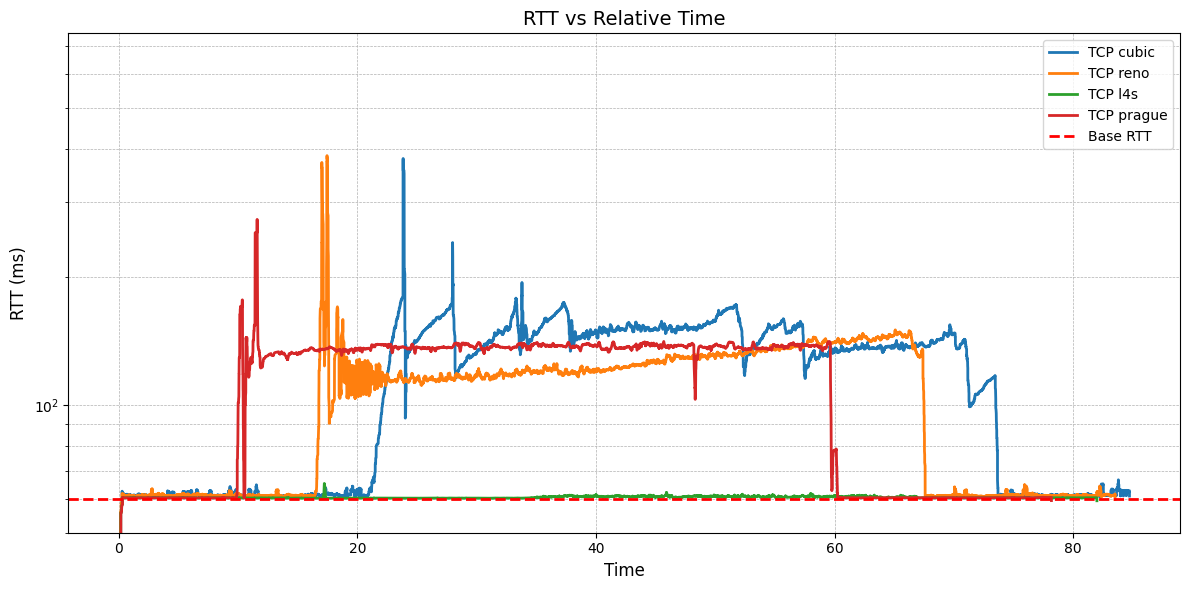

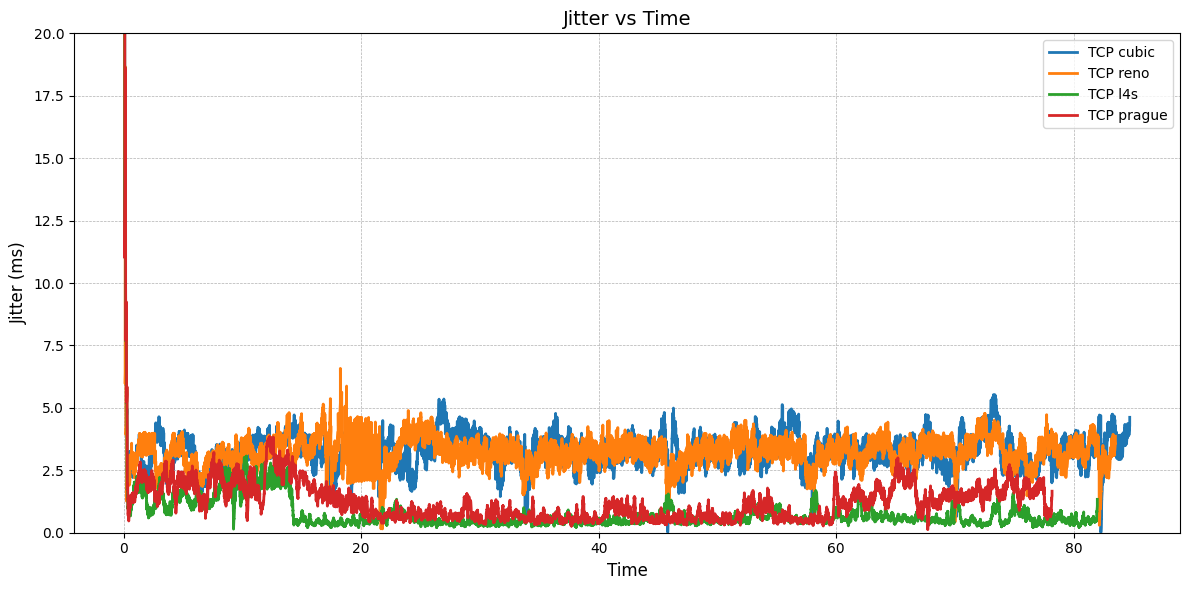

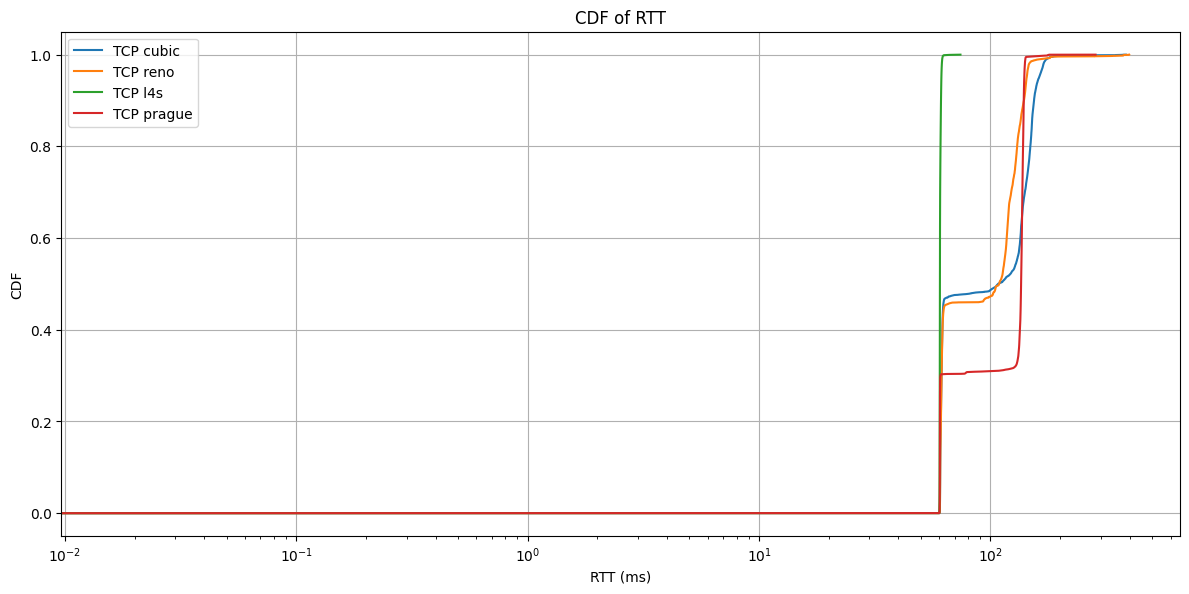

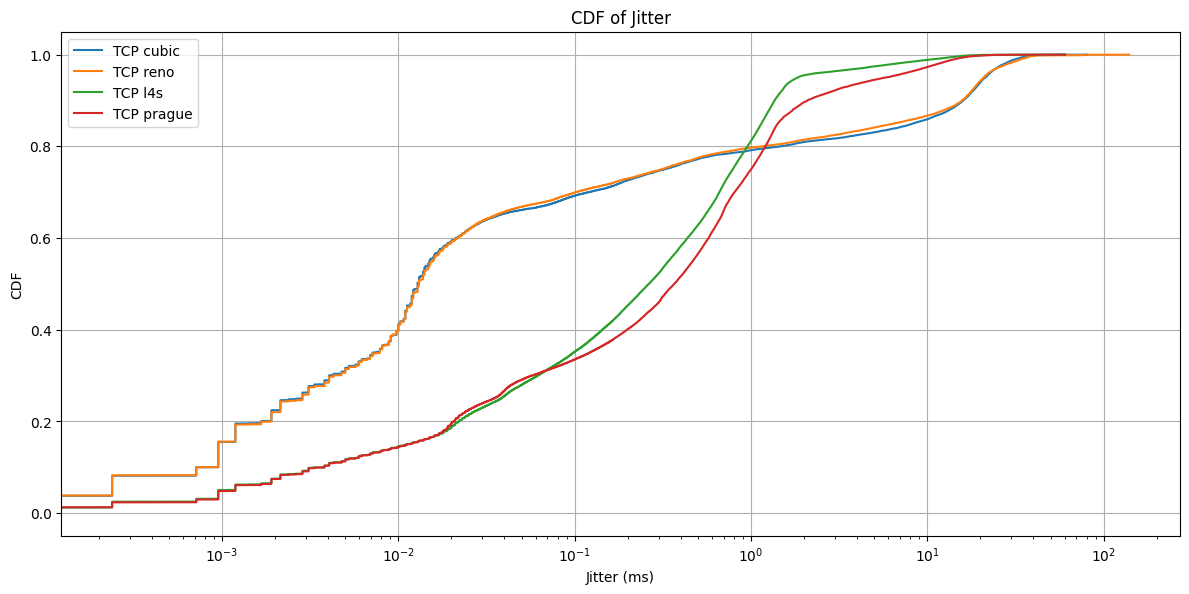

In [11]:
plot_rtt_rolling(dfs, labels, window_size=100)
plot_jitter_rolling(dfs, labels)
plot_rtt_cdf(dfs, labels)
plot_jitter_cdf(dfs, labels)

Packet Drop Percentage for Each Flow:
-------------------------------------
TCP Reno: 0.14%
TCP Cubic: 0.05%
TCP L4s: 0.00%
TCP Prague: 0.02%


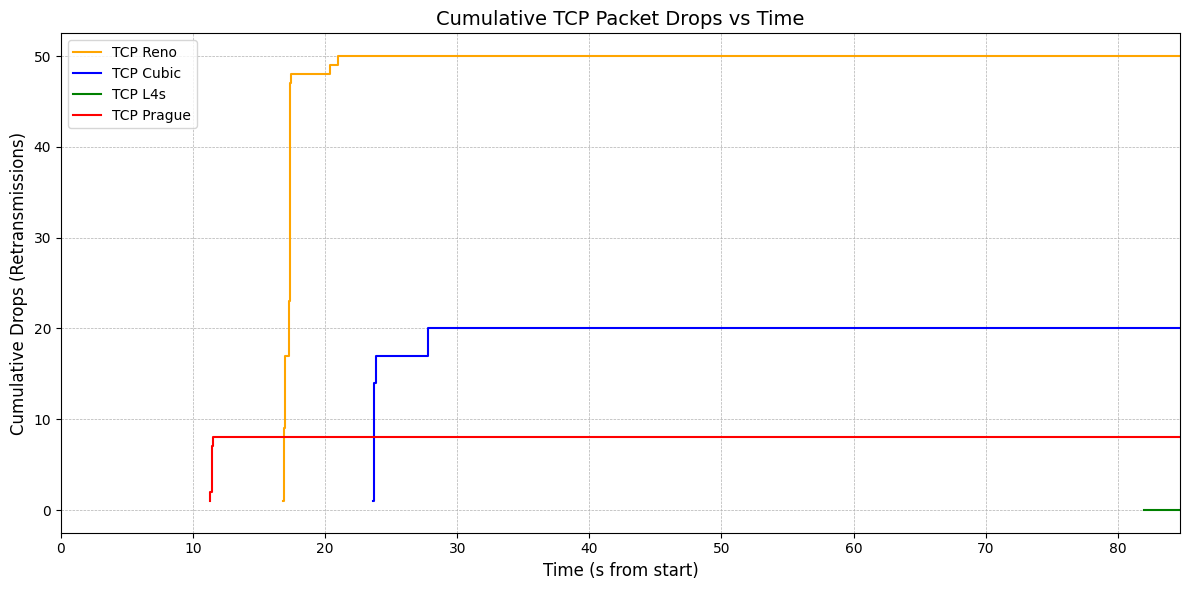


Packet drop percentages have been saved to 'packet_drop_percentages_competings.csv'.


In [ ]:
from scapy.all import rdpcap, TCP
import matplotlib.pyplot as plt
import os
import csv

def get_pkt_drops(pcap_file):
    try:
        packets = rdpcap(pcap_file)
    except FileNotFoundError:
        print(f"File not found: {pcap_file}")
        return None
    except Exception as e:
        print(f"Error reading {pcap_file}: {e}")
        return None

    filtered_packets = [p for p in packets if p.haslayer(TCP) and p[TCP].sport == 5000]
    total_packets = len(filtered_packets)  

    if not filtered_packets:
        print(f"No packets found with TCP source port 5000 in {pcap_file}.")
        return None

    filtered_packets.sort(key=lambda x: x.time)
    start_time = filtered_packets[0].time
    end_time = filtered_packets[-1].time
    rel_end_time = end_time - start_time
    seen_sequences = {}
    cumulative_count = 0
    retransmissions = []

    for p in filtered_packets:
        seq = p[TCP].seq
        pkt_time = p.time
        if seq not in seen_sequences:
            seen_sequences[seq] = pkt_time
        else:
            cumulative_count += 1
            rel_time = pkt_time - start_time
            retransmissions.append((rel_time, cumulative_count))

    base_name = os.path.splitext(os.path.basename(pcap_file))[0]
    protocol = base_name.split('_')[0].capitalize()
    label_name = f'TCP {protocol}'

    if not retransmissions:
        retransmissions = [(rel_end_time, 0)] 

    last_time, last_count = retransmissions[-1]

    return {
        'label': label_name,
        'times': [t for t, c in retransmissions],
        'counts': [c for t, c in retransmissions],
        'end_time': rel_end_time,
        'retransmissions': cumulative_count,
        'total_packets': total_packets
    }


pcap_files = [
    './captures/competing/reno_30_100.pcap',
    './captures/competing/cubic_30_100.pcap',
    './captures/competing/l4s_30_100.pcap',
    './captures/competing/prague_30_100.pcap'
]

data_list = []
for pcap in pcap_files:
    data = get_pkt_drops(pcap)
    if data:
        data_list.append(data)

if not data_list:
    print("No valid data to plot.")
    exit(0)


max_end_time = max(d['end_time'] for d in data_list)


color_map = {'TCP Reno': 'orange', 'TCP Cubic': 'blue', 'TCP L4s': 'green', 'TCP Prague': 'red'}

plt.figure(figsize=(12, 6))


csv_file = 'packet_drop_percentages_competings.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Flow', 'Packet Drop Percentage (%)'])

    print("Packet Drop Percentage for Each Flow:")
    print("-------------------------------------")

    for d in data_list:
        label = d['label']
        retrans = d['retransmissions']
        total = d['total_packets']
        percentage = (retrans / total) * 100 if total > 0 else 0
        print(f"{label}: {percentage:.2f}%")
        writer.writerow([label, f"{percentage:.2f}"])

        times = d['times']
        counts = d['counts']
        color = color_map.get(label, None)
        if color is None:
            color = 'black'  

        if len(times) == 1 and counts[0] == 0:
            
            times.append(max_end_time)
            counts.append(0)
        elif times[-1] < max_end_time:
            
            times.append(max_end_time)
            counts.append(counts[-1])

        plt.step(times, counts, where='post', label=label, color=color)


plt.xlabel("Time (s from start)", fontsize=12)
plt.ylabel("Cumulative Drops (Retransmissions)", fontsize=12)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.title("Cumulative TCP Packet Drops vs Time", fontsize=14)
plt.xlim([0, max_end_time])
plt.tight_layout()
plt.savefig('drops_30_100_competing.pdf')
plt.show()

print(f"\nPacket drop percentages have been saved to '{csv_file}'.")


Processing file: ./captures/competing/cubic_30_100.pcap


/var/folders/pz/k6xzp7dd2d5bmltf7tyypph80000gn/T/ipykernel_31407/2268290786.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  throughput = df.groupby('bin')['bytes'].sum().values


Processing file: ./captures/competing/reno_30_100.pcap


/var/folders/pz/k6xzp7dd2d5bmltf7tyypph80000gn/T/ipykernel_31407/2268290786.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  throughput = df.groupby('bin')['bytes'].sum().values


Processing file: ./captures/competing/l4s_30_100.pcap


/var/folders/pz/k6xzp7dd2d5bmltf7tyypph80000gn/T/ipykernel_31407/2268290786.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  throughput = df.groupby('bin')['bytes'].sum().values


Processing file: ./captures/competing/prague_30_100.pcap


/var/folders/pz/k6xzp7dd2d5bmltf7tyypph80000gn/T/ipykernel_31407/2268290786.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  throughput = df.groupby('bin')['bytes'].sum().values


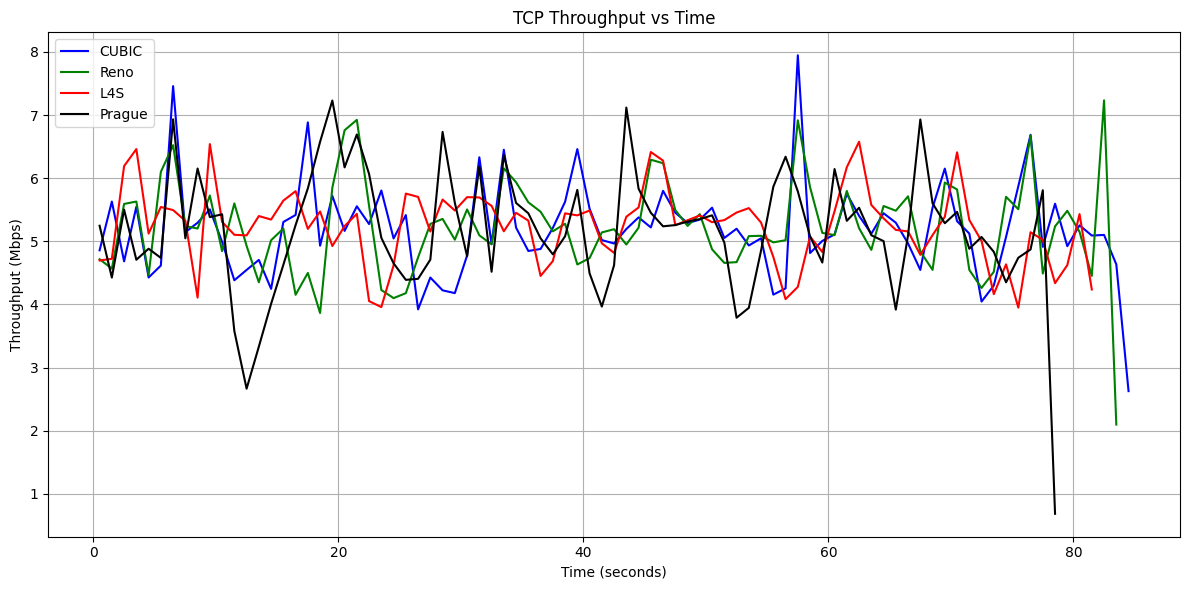

In [ ]:
import os
import sys
from scapy.all import rdpcap, TCP
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def process_pcap(file_path, src_port=5000, bin_size=1):
    print(f"Processing file: {file_path}")
    
    try:
        packets = rdpcap(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        sys.exit(1)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        sys.exit(1)
    
    if not packets:
        print(f"No packets found in {file_path}.")
        return np.array([]), np.array([])

    
    packet_times = []
    packet_lengths = []
    for pkt in packets:
        if TCP in pkt and pkt[TCP].sport == src_port:
            packet_times.append(pkt.time)
            packet_lengths.append(len(pkt))
    
    if not packet_times:
        print(f"No TCP packets with source port {src_port} found in {file_path}.")
        return np.array([]), np.array([])
    df = pd.DataFrame({
        'time': packet_times,
        'bytes': packet_lengths
    })
    start_time = df['time'].min()
    df['time'] = df['time'] - start_time
    max_time = df['time'].max()
    bins = np.arange(0, max_time + bin_size, bin_size)
    df['bin'] = pd.cut(df['time'], bins, right=False)
    throughput = df.groupby('bin')['bytes'].sum().values
    throughput_mbps = (throughput * 8) / (1e6 * bin_size)
    time_bins = bins[:-1] + bin_size / 2 

    return time_bins, throughput_mbps

def main():
    pcaps = [
        './captures/competing/cubic_30_100.pcap',
        './captures/competing/reno_30_100.pcap',
        './captures/competing/l4s_30_100.pcap',
        './captures/competing/prague_30_100.pcap',
    ]

    labels = ['CUBIC', 'Reno', 'L4S', 'Prague']
    colors = ['blue', 'green', 'red','black']

    plt.figure(figsize=(12, 6))
    all_time_bins = []
    all_throughputs = []

    for pcap, label, color in zip(pcaps, labels, colors):
        time_bins, throughput = process_pcap(pcap, src_port=5000, bin_size=1)
        if len(time_bins) == 0:
            print(f"Skipping {pcap} due to no data.")
            continue
        all_time_bins.append(time_bins)
        all_throughputs.append(throughput)
        plt.plot(time_bins, throughput, label=label, color=color)

    if not all_time_bins:
        print("No data to plot.")
        sys.exit(1)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Throughput (Mbps)')
    plt.title('TCP Throughput vs Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('tput_30_100_competing.pdf')
    plt.show()


main()


Processing PCAP Files and Calculating Mean Throughput:
-------------------------------------------------------
Cubic (PCAP): 4.98 Mbps
Reno (PCAP): 5.02 Mbps
L4S (PCAP): 4.96 Mbps
Prague (PCAP): 4.94 Mbps

Mean Throughput for PCAP Flows:
-------------------------------
Cubic (PCAP): 4.98 Mbps
Reno (PCAP): 5.02 Mbps
L4S (PCAP): 4.96 Mbps
Prague (PCAP): 4.94 Mbps

Processing iperf3 JSON Files and Calculating Mean Throughput:
------------------------------------------------------------
Cubic (iperf3): 85.81 Mbps
Reno (iperf3): 85.66 Mbps
L4S (iperf3): 69.99 Mbps
Prague (iperf3): 76.83 Mbps

Mean Throughput for iperf3 Flows:
----------------------------------
Cubic (iperf3): 85.81 Mbps
Reno (iperf3): 85.66 Mbps
L4S (iperf3): 69.99 Mbps
Prague (iperf3): 76.83 Mbps


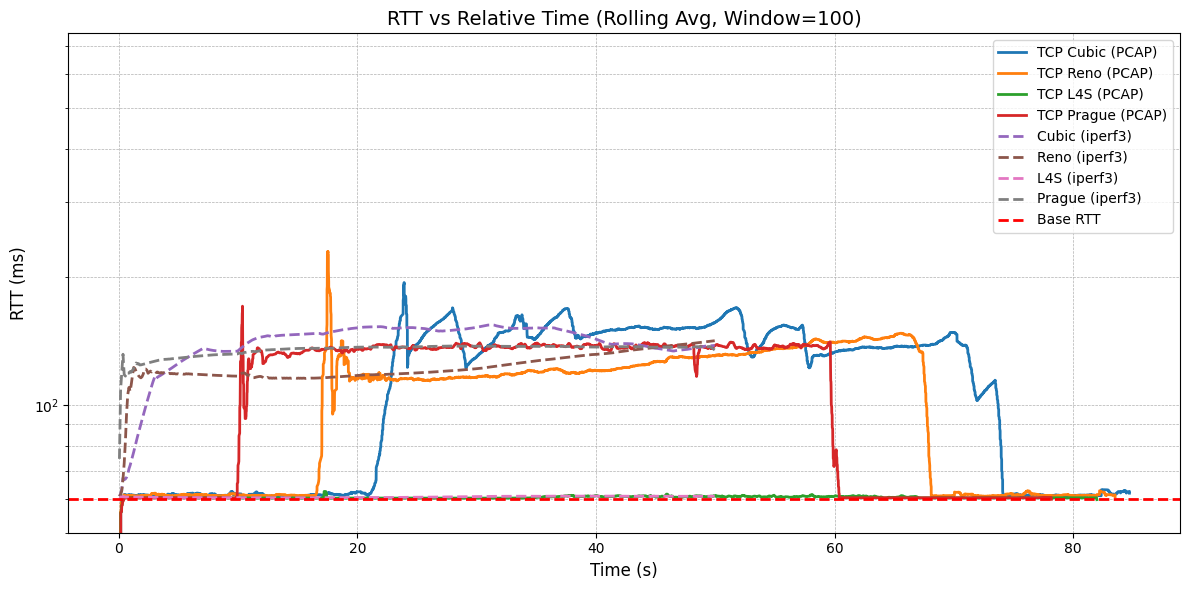

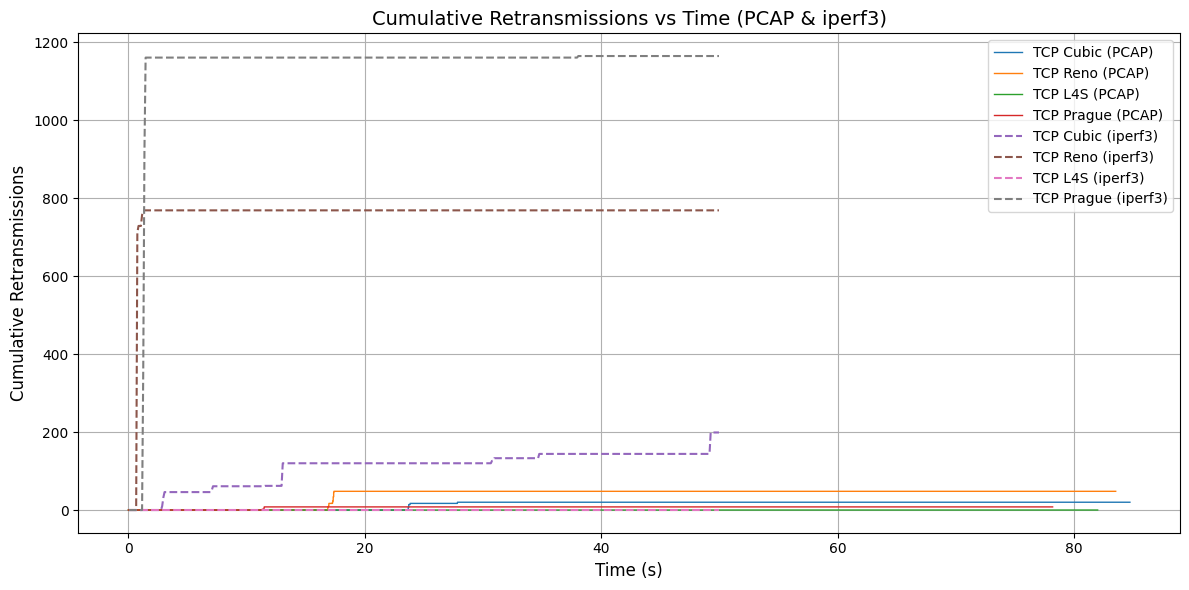


Mean throughput results have been saved to 'mean_throughputs_competings.csv'.


In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import json
import csv
import sys
def process_pcap(pcap_file, port=5000, window_size=100):
    if not os.path.isfile(pcap_file):
        raise FileNotFoundError(f"Pcap file '{pcap_file}' not found.")
    csv_file = os.path.splitext(os.path.basename(pcap_file))[0] + '_data.csv'

    tshark_command = [
        'tshark',
        '-r', pcap_file,
        '-Y', f'tcp.port == {port}',
        '-T', 'fields',
        '-e', 'frame.time_epoch',
        '-e', 'tcp.seq',
        '-e', 'tcp.len',
        '-e', 'tcp.analysis.retransmission',
        '-e', 'tcp.analysis.ack_rtt',
        '-E', 'header=y',
        '-E', 'separator=,',
        '-E', 'quote=d',
        '-E', 'occurrence=f'
    ]
    try:
        with open(csv_file, 'w') as f:
            subprocess.run(tshark_command, stdout=f, stderr=subprocess.PIPE, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Error processing {pcap_file} with tshark: {e.stderr.decode().strip()}")
        return None
    try:
        df = pd.read_csv(
            csv_file,
            names=['timestamp', 'seq', 'len', 'retransmission', 'ack_rtt'],
            header=0,
            dtype={
                'timestamp': float,
                'seq': int,
                'len': int,
                'retransmission': str,
                'ack_rtt': float
            }
        )
    except Exception as e:
        print(f"Error reading CSV data from {csv_file}: {e}")
        return None

    if df.empty:
        print(f"No data extracted from {pcap_file}.")
        return None
    df.sort_values('timestamp', inplace=True)
    df['relative_time'] = df['timestamp'] - df['timestamp'].iloc[0]
    df['jitter_ms'] = df['timestamp'].diff().fillna(0) * 1000
    df['rtt_ms'] = df['ack_rtt'] * 1000
    df['cumulative_retrans'] = df['retransmission'].notna().cumsum()
    total_bytes = df['len'].sum()
    duration = df['relative_time'].iloc[-1] if not df['relative_time'].empty else 0
    throughput_mbps = (total_bytes * 8) / (duration * 1e6) if duration > 0 else 0
    df['throughput_mbps'] = (df['len'] * 8) / (1e6 * 1) 

    return df, throughput_mbps, duration, total_bytes

def process_iperf3(json_file):
    if not os.path.isfile(json_file):
        print(f"iperf3 JSON file '{json_file}' not found.")
        return None

    with open(json_file, 'r') as f:
        try:
            data = json.load(f)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON from {json_file}: {e}")
            return None

    time_stamps = []
    rtts = []
    retransmissions = []
    bits_per_second = []
    cumulative_retrans = 0

    for interval in data.get('intervals', []):
        stream = interval.get('streams', [])[0] if interval.get('streams') else {}
        start_time = stream.get('start', 0)
        end_time = stream.get('end', 0)
        time_midpoint = (start_time + end_time) / 2

        time_stamps.append(time_midpoint)
        rtts.append(stream.get('rtt', 0) / 1000)  
        cumulative_retrans += stream.get('retransmits', 0)
        retransmissions.append(cumulative_retrans)
        bits_per_second.append(stream.get('bits_per_second', 0) / 1e6) 

    df = pd.DataFrame({
        'relative_time': time_stamps,
        'rtt_ms': rtts,
        'cumulative_retrans': retransmissions,
        'throughput_mbps': bits_per_second
    })
    return df

def plot_rtt_rolling(pcap_dfs, iperf_dfs, pcap_labels, iperf_labels, window_size=100):
    plt.figure(figsize=(12, 6))
    
    for df, label in zip(pcap_dfs, pcap_labels):
        if df is not None and df['rtt_ms'].notna().any():
            df_clean = df.dropna(subset=['relative_time', 'rtt_ms'])
            df_sorted = df_clean.sort_values('relative_time')
            df_sorted['rtt_roll_avg'] = df_sorted['rtt_ms'].rolling(window=window_size, min_periods=1).mean()
            plt.plot(df_sorted['relative_time'], df_sorted['rtt_roll_avg'], 
                     label=f'TCP {label} (PCAP)', linestyle='-', linewidth=2)
    
    for df, label in zip(iperf_dfs, iperf_labels):
        if df is not None and df['rtt_ms'].notna().any():
            df_clean = df.dropna(subset=['relative_time', 'rtt_ms'])
            df_sorted = df_clean.sort_values('relative_time')
            df_sorted['rtt_roll_avg'] = df_sorted['rtt_ms'].rolling(window=window_size, min_periods=1).mean()
            plt.plot(df_sorted['relative_time'], df_sorted['rtt_roll_avg'], 
                     label=f'{label} (iperf3)', linestyle='--', linewidth=2)
    plt.axhline(y=60, color='red', linestyle='--', linewidth=2, label='Base RTT')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('RTT (ms)', fontsize=12)
    plt.title(f'RTT vs Relative Time (Rolling Avg, Window={window_size})', fontsize=14)
    plt.ylim([50, 750])
    plt.yscale('log')
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig('tput_30_100_competing_all.pdf')
    plt.show()


def plot_retrans_combined(pcap_dfs, iperf_dfs, labels_pcap, labels_iperf):
    plt.figure(figsize=(12, 6))
    for df, label in zip(pcap_dfs, labels_pcap):
        if df is not None:
            plt.plot(df['relative_time'], df['cumulative_retrans'], label=f'TCP {label} (PCAP)', linewidth=1)
    for df, label in zip(iperf_dfs, labels_iperf):
        if df is not None:
            plt.plot(df['relative_time'], df['cumulative_retrans'], label=f'TCP {label} (iperf3)', linestyle='--')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Cumulative Retransmissions', fontsize=12)
    plt.title('Cumulative Retransmissions vs Time (PCAP & iperf3)', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('retrans_30_100_competing_all.pdf')
    plt.show()

def main():
    pcaps = [
        './captures/competing/cubic_30_100.pcap',
        './captures/competing/reno_30_100.pcap',
        './captures/competing/l4s_30_100.pcap',
        './captures/competing/prague_30_100.pcap'  
    ]
    pcap_labels = ['Cubic', 'Reno', 'L4S', 'Prague']
    pcap_dfs = []
    pcap_throughputs = []
    

    print("Processing PCAP Files and Calculating Mean Throughput:")
    print("-------------------------------------------------------")
    for pcap, label in zip(pcaps, pcap_labels):
        try:
            df, throughput_mbps, duration, total_bytes = process_pcap(pcap, port=5000)
            if df is not None:
                pcap_dfs.append(df)
                pcap_throughputs.append((label, throughput_mbps))
                print(f"{label} (PCAP): {throughput_mbps:.2f} Mbps")
            else:
                pcap_dfs.append(None)
                pcap_throughputs.append((label, 0))
                print(f"{label} (PCAP): No data available.")
        except FileNotFoundError as e:
            print(e)
            pcap_dfs.append(None)
            pcap_throughputs.append((label, 0))
        except Exception as e:
            print(f"Error processing {pcap}: {e}")
            pcap_dfs.append(None)
            pcap_throughputs.append((label, 0))
    
    print("\nMean Throughput for PCAP Flows:")
    print("-------------------------------")
    for label, tput in pcap_throughputs:
        print(f"{label} (PCAP): {tput:.2f} Mbps")
    
    iperf_files = [
        './captures/competing/iperf3/cubic_30_100_iperf_client.json',
        './captures/competing/iperf3/reno_30_100_iperf_client.json',
        './captures/competing/iperf3/l4s_30_100_iperf_client.json',
        './captures/competing/iperf3/prague_30_100_iperf_client.json' 
    ]
    iperf_labels = ['Cubic', 'Reno', 'L4S', 'Prague'] 
    iperf_dfs = []
    iperf_mean_throughputs = []
    
    print("\nProcessing iperf3 JSON Files and Calculating Mean Throughput:")
    print("------------------------------------------------------------")
    for json_file, label in zip(iperf_files, iperf_labels):
        df = process_iperf3(json_file)
        if df is not None and not df.empty:
            iperf_dfs.append(df)
            mean_tput = df['throughput_mbps'].mean()
            iperf_mean_throughputs.append((label, mean_tput))
            print(f"{label} (iperf3): {mean_tput:.2f} Mbps")
        else:
            iperf_dfs.append(None)
            iperf_mean_throughputs.append((label, 0))
            print(f"{label} (iperf3): No data available.")
    
    print("\nMean Throughput for iperf3 Flows:")
    print("----------------------------------")
    for label, tput in iperf_mean_throughputs:
        print(f"{label} (iperf3): {tput:.2f} Mbps")
    
    plot_rtt_rolling(pcap_dfs, iperf_dfs, pcap_labels, iperf_labels)
    plot_retrans_combined(pcap_dfs, iperf_dfs, pcap_labels, iperf_labels)
    
    csv_output = 'mean_throughputs_competings.csv'
    with open(csv_output, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Flow', 'Mean Throughput (Mbps)', 'Source'])
        for (label, tput) in pcap_throughputs:
            writer.writerow([label, f"{tput:.2f}", 'PCAP'])
        for (label, tput) in iperf_mean_throughputs:
            writer.writerow([label, f"{tput:.2f}", 'iperf3'])
    
    print(f"\nMean throughput results have been saved to '{csv_output}'.")


main()
